<a href="https://colab.research.google.com/github/jdanion/CoroTroch/blob/main/couronneTrochoidale.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q cadquery cadquery-ocp
!pip install trimesh matplotlib

from google.colab import output
output.enable_custom_widget_manager()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.9/163.9 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.0/143.0 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 436.8/436.8 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.3/77.3 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.1/45.1 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 712.0/712.0 kB 5.5 MB/s eta 0:00:00


Gear center: (-35.0, 0.0, 110.0)
Pinion center: (0.0, 0.0, 35.0)


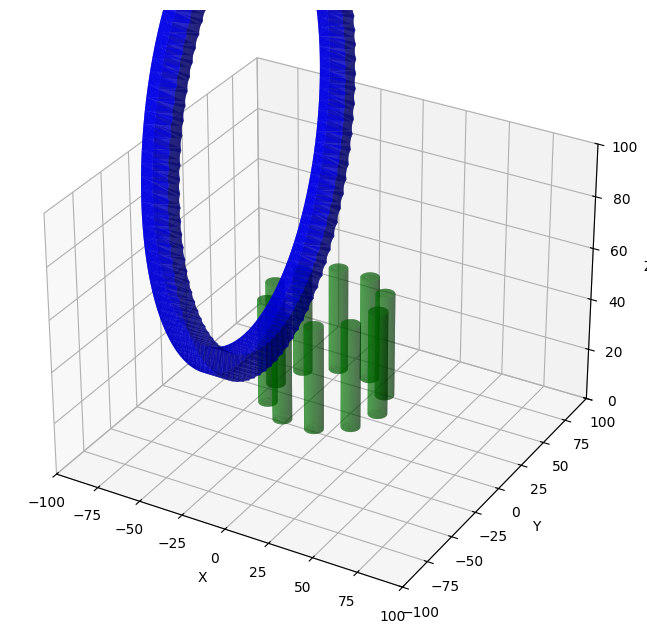

[Final] gear_final_100_steps.step exported to Google Drive.
[Final] pinion_final_100_steps.step exported to Google Drive.


In [8]:
# === LIBRARY IMPORTS ===

# 3D modeling and geometry
import cadquery as cq
import math
import trimesh
import numpy as np
import tempfile

# Visualization
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# File handling
import os

# === EXPORT TO GOOGLE DRIVE ===
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate user for Google Drive access
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def create_or_get_drive_folder(folder_name):
    """
    Create a folder in Google Drive if it does not exist and return its ID.
    """
    file_list = drive.ListFile({'q': f"title='{folder_name}' and mimeType='application/vnd.google-apps.folder' and trashed=false"}).GetList()
    if file_list:
        return file_list[0]['id']
    folder_metadata = {'title': folder_name, 'mimeType': 'application/vnd.google-apps.folder'}
    folder = drive.CreateFile(folder_metadata)
    folder.Upload()
    return folder['id']


# === MODEL PARAMETERS ===

gear_outer_diameter = 180    # Outer diameter of the main gear
ingear_height = 30           # Height (thickness) of the gear
gear_wall_thickness = 10     # Thickness of the gear ring

cylinder_diameter = 10        # Diameter of small cylinders composing the pinion
cylinder_height = 40         # Height of those cylinders
placement_radius = 30        # Distance from center of pinion to cylinder center
number_of_cylinders = 10     # Number of cylinders in the pinion
pinion_gear_ratio = 20       # Gear reduction ratio


# === UTILITY FUNCTIONS ===

def cadquery_to_trimesh(cq_object):
    """
    Convert a CadQuery object to a Trimesh mesh via temporary STL export.
    """
    with tempfile.NamedTemporaryFile(suffix=".stl", delete=False) as tmp_file:
        cq.exporters.export(cq_object, tmp_file.name)
        mesh = trimesh.load(tmp_file.name)
    os.unlink(tmp_file.name)
    return mesh

def visualize_meshes(meshes, colors, alphas):
    """
    Display a list of Trimesh meshes in a 3D matplotlib plot.
    """
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    for mesh, color, alpha in zip(meshes, colors, alphas):
        ax.plot_trisurf(mesh.vertices[:, 0], mesh.vertices[:, 1], mesh.vertices[:, 2],
                        triangles=mesh.faces, shade=True, color=color, alpha=alpha)

    ax.set_xlim(-100, 100)
    ax.set_ylim(-100, 100)
    ax.set_zlim(0, 100)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()


# === GEOMETRIC CONSTRUCTION FUNCTIONS ===

def create_gear():
    """
    Create a ring gear by subtracting a smaller cylinder from a larger one.
    """
    outer = cq.Workplane("YZ").circle(gear_outer_diameter / 2).extrude(-ingear_height)
    inner = cq.Workplane("YZ").circle(gear_outer_diameter / 2 - gear_wall_thickness).extrude(-ingear_height)
    gear = outer.cut(inner)
    return gear.translate((ingear_height/2, 0.0, 0))

def create_pinion():
    """
    Create a pinion composed of equally spaced vertical cylinders in a circular pattern.
    """
    cylinders = []
    for i in range(number_of_cylinders):
        angle_deg = i * (360 / number_of_cylinders)
        x = placement_radius * math.cos(math.radians(angle_deg))
        y = placement_radius * math.sin(math.radians(angle_deg))
        cylinder = cq.Workplane("XY").center(x, y).circle(cylinder_diameter / 2).extrude(cylinder_height)
        cylinders.append(cylinder)
    pinion = cylinders[0]
    for cyl in cylinders[1:]:
        pinion = pinion.union(cyl)
    return pinion.translate((0.0, 0.0, -cylinder_height / 2))

def compute_center(cq_object):
    """
    Compute the geometric center of a CadQuery object via its bounding box.
    """
    solid = cq_object.val()
    bbox = solid.BoundingBox()
    return ((bbox.xmin + bbox.xmax) / 2,
            (bbox.ymin + bbox.ymax) / 2,
            (bbox.zmin + bbox.zmax) / 2)


# === STEP EXPORT FUNCTION ===

def save_every_50_steps(step, gear, pinion, folder_id):
    """
    Save STEP files locally and upload to Google Drive every 100 steps.
    """
    if step % 50 == 0:
        gear_filename = f'gear_step_{step}.step'
        pinion_filename = f'pinion_step_{step}.step'

        cq.exporters.export(gear, gear_filename)
        cq.exporters.export(pinion, pinion_filename)

        for filename in [gear_filename, pinion_filename]:
            uploaded = drive.CreateFile({'title': filename, 'parents': [{'id': folder_id}]})
            uploaded.SetContentFile(filename)
            uploaded.Upload()
            print(f"[Step {step}] {filename} exported to Google Drive.")


# === SIMULATION FUNCTION ===

def simulate_pinion_gear_rotation(iterations, on_iteration=None, folder_id=None):
    """
    Simulate the coupled rotation of a pinion and ring gear.
    Calls a callback function at each step (e.g., for export).
    """
    angle_gear = 360 / iterations
    angle_pinion = -pinion_gear_ratio * angle_gear

    pinion = create_pinion()
    gear = create_gear()

    pinion = pinion.translate((0, 0, cylinder_height - gear_wall_thickness / 2))
    gear = gear.translate((-placement_radius - ingear_height/2 + cylinder_diameter,
                           0, gear_outer_diameter / 2 + cylinder_height / 2))

    center_gear = compute_center(gear)
    center_pinion = compute_center(pinion)

    print("Gear center:", center_gear)
    print("Pinion center:", center_pinion)

    for step in range(iterations):
        gear = gear.cut(pinion)
        pinion = pinion.rotate(center_pinion,
                               (center_pinion[0], center_pinion[1], center_pinion[2] + 1),
                               angle_pinion)
        gear = gear.rotate(center_gear,
                           (center_gear[0] + 1, center_gear[1], center_gear[2]),
                           angle_gear)

        if on_iteration:
            on_iteration(step, gear, pinion, folder_id)

    mesh_gear = cadquery_to_trimesh(gear)
    mesh_pinion = cadquery_to_trimesh(pinion)

    visualize_meshes([mesh_gear, mesh_pinion],
                     colors=['blue', 'green'],
                     alphas=[0.8, 0.5])

    # Final export with iteration count in filename
    gear_file = f'gear_final_{iterations}_steps.step'
    pinion_file = f'pinion_final_{iterations}_steps.step'

    cq.exporters.export(gear, gear_file)
    cq.exporters.export(pinion, pinion_file)

    for filename in [gear_file, pinion_file]:
        uploaded = drive.CreateFile({'title': filename, 'parents': [{'id': folder_id}]})
        uploaded.SetContentFile(filename)
        uploaded.Upload()
        print(f"[Final] {filename} exported to Google Drive.")


# === MAIN EXECUTION ===

folder_id = create_or_get_drive_folder("Simu_Gear_Pinions")
simulate_pinion_gear_rotation(100, folder_id=folder_id)


In [ ]:
# === LIBRARY IMPORTS ===

# 3D modeling and geometry
import cadquery as cq
import math
import trimesh
import numpy as np
import tempfile

# Visualization
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# File handling
import os


# === MODEL PARAMETERS ===

# External gear (ring gear) dimensions
gear_outer_diameter = 140    # Total diameter of the gear
gear_height = 30             # Axial thickness (Z direction)
gear_wall_thickness = 20     # Radial wall thickness of the ring

# Pinion parameters: small cylinders positioned in a circular array
cylinder_diameter = 8        # Diameter of each pinion cylinder
cylinder_height = 40         # Height (Z direction) of the cylinders
placement_radius = 20        # Radius at which pinion cylinders are placed from the center
number_of_cylinders = 8      # Total number of cylinders forming the pinion
pinion_rpm_ratio = 3        # Ratio between pinion revolution and gear revolution


# === UTILITY FUNCTIONS ===

def cadquery_to_trimesh(cq_object):
    """
    Converts a CadQuery solid object into a trimesh mesh by exporting to STL.
    Used for visualization with matplotlib.
    """
    with tempfile.NamedTemporaryFile(suffix=".stl", delete=False) as tmp_file:
        cq.exporters.export(cq_object, tmp_file.name)
        mesh = trimesh.load(tmp_file.name)
    os.unlink(tmp_file.name)  # Remove temporary STL file
    return mesh


def visualize_meshes(meshes, colors, alphas):
    """
    Visualizes a list of triangular meshes using matplotlib in 3D.

    Parameters:
    - meshes: list of trimesh objects
    - colors: list of color strings (e.g., 'blue', 'green')
    - alphas: list of alpha values (0 = transparent, 1 = opaque)
    """
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    for mesh, color, alpha in zip(meshes, colors, alphas):
        ax.plot_trisurf(mesh.vertices[:, 0], mesh.vertices[:, 1], mesh.vertices[:, 2],
                        triangles=mesh.faces, shade=True, color=color, alpha=alpha)

    # Set axis limits and labels
    ax.set_xlim(-100, 100)
    ax.set_ylim(-100, 100)
    ax.set_zlim(0, 100)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    plt.show()


# === GEOMETRIC CONSTRUCTION FUNCTIONS ===

def create_gear():
    """
    Constructs a hollow ring gear by subtracting a central cylinder from a larger one.
    Positioned and translated for later assembly.

    Returns:
    - CadQuery object representing the ring gear
    """
    # Create the outer cylinder (base disk)
    outer = (cq.Workplane("YZ")
             #.center(-(placement_radius + cylinder_diameter + gear_height), gear_outer_diameter / 2)
             .circle(gear_outer_diameter / 2)
             .extrude(-gear_height))

    # Create the inner void (central hole)
    inner = (cq.Workplane("YZ")
             #.center(-(placement_radius + cylinder_diameter + gear_height), gear_outer_diameter / 2)
             .circle(gear_outer_diameter / 2 - gear_wall_thickness)
             .extrude(-gear_height))

    # Subtract to form the gear
    gear = outer.cut(inner)

    # Center the gear with pinion center
    gear = gear.translate((gear_height/2, 0, 0))

    return gear


def create_pinion():
    """
    Builds the pinion as an array of cylinders evenly distributed in a circular layout.

    Returns:
    - CadQuery object representing the assembled pinion
    """
    cylinders = []
    for i in range(number_of_cylinders):
        angle_deg = i * (360 / number_of_cylinders)
        x = placement_radius * math.cos(math.radians(angle_deg))
        y = placement_radius * math.sin(math.radians(angle_deg))

        cylinder = (cq.Workplane("XY")
                    .center(x, y)
                    .circle(cylinder_diameter / 2)
                    .extrude(cylinder_height))
        cylinders.append(cylinder)

    # Merge all cylinders into a single solid
    pinion = cylinders[0]
    for cylinder in cylinders[1:]:
        pinion = pinion.union(cylinder)

    # Center the pinion vertically
    pinion = pinion.translate((0.0, 0.0, -cylinder_height / 2))
    return pinion


def compute_center(cq_object):
    """
    Computes the geometric center (centroid) of a CadQuery object using its bounding box.

    Returns:
    - Tuple (x, y, z) representing the center point
    """
    solid = cq_object.val()
    bbox = solid.BoundingBox()
    return ((bbox.xmin + bbox.xmax) / 2,
            (bbox.ymin + bbox.ymax) / 2,
            (bbox.zmin + bbox.zmax) / 2)


# === SIMULATION FUNCTION ===

def simulate_pinion_gear_rotation(iterations):
    """
    Simulates multiple iterations of rotation and interaction between a pinion and a gear.
    At each step, the pinion is rotated negatively and the gear positively, and their volumes interact.

    Parameters:
    - iterations: number of rotation steps
    """
    angle_gear = 360 / iterations     # Rotation per step for the gear
    angle_pinion = -pinion_rpm_ratio*angle_gear        # Opposite rotation for the pinion with ratio ajustment

    pinion = create_pinion()
    gear = create_gear()

    # Initial spatial alignment of components

    # Translate to a reference position in space 90° with contact
    gear = gear.translate((-(placement_radius  - cylinder_diameter/2),0, gear_outer_diameter / 2 + cylinder_height / 2))
    pinion = pinion.translate((0, 0, cylinder_height - gear_wall_thickness / 2))
    #gear = gear.translate((-(placement_radius  - cylinder_diameter/2) ,
     #                      0, gear_outer_diameter / 2 + cylinder_height / 2))

    # Determine rotation centers
    center_gear = compute_center(gear)
    center_pinion = compute_center(pinion)

    print("Gear center:", center_gear)
    print("Pinion center:", center_pinion)

    # Perform the rotation and cutting sequence
    for _ in range(iterations):
        gear = gear.cut(pinion)  # Simulate interaction by subtracting pinion volume
        pinion = pinion.rotate(center_pinion,
                               (center_pinion[0], center_pinion[1], center_pinion[2] + 1),
                               angle_pinion)
        gear = gear.rotate(center_gear,
                           (center_gear[0] + 1, center_gear[1], center_gear[2]),
                           angle_gear)

    # Export and visualize final state
    mesh_gear = cadquery_to_trimesh(gear)
    mesh_pinion = cadquery_to_trimesh(pinion)

    visualize_meshes([mesh_gear, mesh_pinion],
                     colors=['blue', 'green'],
                     alphas=[0.8, 0.5])

    # Export CAD models in STEP format
    cq.exporters.export(gear, 'gear_final.step')
    cq.exporters.export(pinion, 'pinion_final.step')


# === MAIN EXECUTION ===

simulate_pinion_gear_rotation(300)


Gear center: (-16.0, 0.0, 90.0)
Pinion center: (0.0, 0.0, 30.0)


In [ ]:

import cadquery as cq
import math
import trimesh
import numpy as np
import tempfile
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# === PARAMÈTRES ===
# Paramètres de la couronne

diametre_couronne = 80
hauteur_couronne = 20

# Paramètres pour les cylindres du pignon
diametre_cylindre = 8
hauteur_cylindre = 20
rayon_positionnement = 20  # Rayon sur lequel les cylindres sont positionnés
nombre_cylindres = 8


# Fonction pour convertir un objet CadQuery en maillage trimesh
def cadquery_to_trimesh(cadquery_object):
    with tempfile.NamedTemporaryFile(suffix=".stl", delete=False) as tmp_file:
        cq.exporters.export(cadquery_object, tmp_file.name)
        mesh = trimesh.load(tmp_file.name)
    os.unlink(tmp_file.name)  # Supprime le fichier temporaire
    return mesh

# Fonction pour visualiser les maillages avec matplotlib
def visualiser(meshes, colors, alphas):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    for mesh, couleur, alpha in zip(meshes, colors, alphas):
        ax.plot_trisurf(mesh.vertices[:, 0], mesh.vertices[:, 1], mesh.vertices[:, 2],
                        triangles=mesh.faces, shade=True, color=couleur, alpha=alpha)
    ax.set_xlim(-100,100)
    ax.set_ylim(-100,100)
    ax.set_zlim(0,100)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()


# === CRÉATION DE LA COURONNE ===
def creer_couronne():
  # Créer le disque plein
  base = (cq.Workplane("YZ")
                .center(-(rayon_positionnement+diametre_cylindre),diametre_couronne/2)
                .circle(diametre_couronne / 2)
                .extrude(-hauteur_couronne))

# Créer le cylindre central à soustraire
  vide = (cq.Workplane("YZ")
                    .center(-(rayon_positionnement+diametre_cylindre),diametre_couronne/2)
                    .circle(diametre_couronne / 2 -hauteur_cylindre)
                    .extrude(-hauteur_couronne))

# Soustraire le cylindre central du disque plein pour obtenir la couronne
  couronne = base.cut(vide)

  couronne = couronne.translate((10.0, 28.0, -diametre_couronne/2))

  return couronne

# === CRÉATION DU PIGNON AVEC CYLINDRES ===
def creer_pignon():
    cylindres = []
    for i in range(nombre_cylindres):
        angle = i * (360 / nombre_cylindres)
        x = rayon_positionnement * math.cos(math.radians(angle))
        y = rayon_positionnement * math.sin(math.radians(angle))

        cylindre = (cq.Workplane("XY")
                    .center(x, y)
                    .circle(diametre_cylindre / 2)
                    .extrude(hauteur_cylindre))
        cylindres.append(cylindre)

    pignon = cylindres[0]
    for cylindre in cylindres[1:]:
        pignon = pignon.union(cylindre)
    pignon = pignon.translate((0.0, 0.0, -hauteur_cylindre/2))
    return pignon

def calculer_centre(objet):
    objet_solid = objet.val()
    bbox = objet_solid.BoundingBox()
    centre_x = (bbox.xmin + bbox.xmax) / 2
    centre_y = (bbox.ymin + bbox.ymax) / 2
    centre_z = (bbox.zmin + bbox.zmax) / 2
    return (centre_x, centre_y, centre_z)

def rotation_pigon_couronne_simultanee(nb_iteration):
    angle_couronne = 360/nb_iteration  # Angle de rotation en degrés
    angle_pignon = angle_couronne

    pignon = creer_pignon()
    couronne = creer_couronne()



    pignon = pignon.translate((0,0,hauteur_cylindre))
    couronne = couronne.translate((-rayon_positionnement-hauteur_couronne/2+diametre_cylindre,0,diametre_couronne/2))
    centre_couronne = calculer_centre(couronne)
    print("Centre de la couronne :", centre_couronne)
    centre_pignon = calculer_centre(pignon)
    print("Centre du pignon :", centre_pignon)
    for i in range(nb_iteration):

        intersection = pignon.intersect(couronne)
        couronne = couronne.cut(pignon)
        #mesh_intersection = cadquery_to_trimesh(intersection)
        #mesh_pignon = cadquery_to_trimesh(pignon)
        #mesh_couronne = cadquery_to_trimesh(couronne)
        #visualiser(
        #[mesh_couronne, mesh_pignon, mesh_intersection],
        #colors=['blue', 'green', 'red'],
        #alphas=[0.1, 0.1, 0.8]  # Transparences pour couronne, pignon, et intersection
    #)
        pignon = pignon.rotate((centre_pignon), (centre_pignon[0], centre_pignon[1], centre_pignon[2]+1), angle_pignon)
        couronne = couronne.rotate((centre_couronne),(centre_couronne[0]+1,centre_couronne[1],centre_couronne[2]),angle_couronne)

    mesh_couronne = cadquery_to_trimesh(couronne)
    mesh_pignon = cadquery_to_trimesh(pignon)
    mesh_intersection = cadquery_to_trimesh(intersection)
    meshes = [mesh_couronne, mesh_pignon, mesh_intersection]
    colors = ['blue', 'green', 'red']
    alphas = [0.1, 0.1, 0.8]
    visualiser(meshes,colors,alphas)

rotation_pigon_couronne_simultanee(360)


Centre de la couronne : (-22.0, 0.0, 40.0)
Centre du pignon : (0.0, 0.0, 20.0)


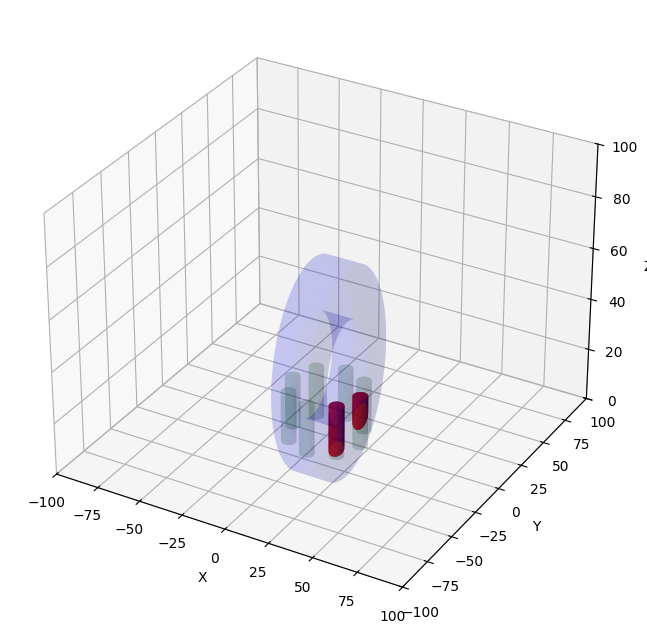

In [ ]:
import cadquery as cq
import math
import trimesh
import numpy as np
import tempfile
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# === PARAMÈTRES ===
diametre_couronne = 80
hauteur_couronne = 20

# Paramètres pour les cylindres du pignon
diametre_cylindre = 8
hauteur_cylindre = 20
rayon_positionnement = 20
nombre_cylindres = 8

# Calcul du décalage
decalage = diametre_couronne / 2

# Fonction pour convertir un objet CadQuery en maillage trimesh
def cadquery_to_trimesh(cadquery_object):
    temp_file = tempfile.NamedTemporaryFile(suffix=".stl", delete=False)
    try:
        cq.exporters.export(cadquery_object, temp_file.name)
        mesh = trimesh.load(temp_file.name)
    finally:
        os.unlink(temp_file.name)  # Supprime le fichier temporaire
    return mesh

# Fonction pour visualiser les maillages avec matplotlib
def visualiser(meshes, colors, alphas):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    for mesh, couleur, alpha in zip(meshes, colors, alphas):
        ax.plot_trisurf(mesh.vertices[:, 0], mesh.vertices[:, 1], mesh.vertices[:, 2],
                        triangles=mesh.faces, shade=True, color=couleur, alpha=alpha)
    ax.set_xlim(-100, 100)
    ax.set_ylim(-100, 100)
    ax.set_zlim(0, 100)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()

# === CRÉATION DE LA COURONNE ===
def creer_couronne():
    disque_plein = (cq.Workplane("YZ")
                    .center(-(rayon_positionnement + diametre_cylindre), diametre_couronne / 2)
                    .circle(diametre_couronne / 2)
                    .extrude(-hauteur_couronne))

    cylindre_central = (cq.Workplane("YZ")
                        .center(-(rayon_positionnement + diametre_cylindre), diametre_couronne / 2)
                        .circle(diametre_couronne / 2 - hauteur_cylindre)
                        .extrude(-hauteur_couronne))

    couronne = disque_plein.cut(cylindre_central)

    return couronne

# === CRÉATION DU PIGNON AVEC CYLINDRES ===
def creer_pignon():
    cylindres = []
    for i in range(nombre_cylindres):
        angle = i * (360 / nombre_cylindres)
        x = rayon_positionnement * math.cos(math.radians(angle))
        y = rayon_positionnement * math.sin(math.radians(angle))

        cylindre = (cq.Workplane("XY")
                    .center(x, y)
                    .circle(diametre_cylindre / 2)
                    .extrude(hauteur_cylindre))
        cylindres.append(cylindre)

    pignon = cylindres[0]
    for cylindre in cylindres[1:]:
        pignon = pignon.union(cylindre)



    return pignon

def rotation_pignon_couronne_simultanee(nb_iteration):
    angle_couronne = 360 / nb_iteration
    angle_pignon = angle_couronne * (1 + diametre_couronne / (2 * rayon_positionnement))

    pignon = creer_pignon()
    couronne = creer_couronne()

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    for i in range(nb_iteration):
        ax.clear()
        try:
            intersection = pignon.intersect(couronne)
            couronne = couronne.cut(pignon)

            # Vérifiez si l'intersection est un maillage valide
            if hasattr(intersection, 'val') and intersection.val().Vertices():
                mesh_intersection = cadquery_to_trimesh(intersection)
                mesh_pignon = cadquery_to_trimesh(pignon)
                mesh_couronne = cadquery_to_trimesh(couronne)

                ax.plot_trisurf(mesh_couronne.vertices[:, 0], mesh_couronne.vertices[:, 1], mesh_couronne.vertices[:, 2],
                                triangles=mesh_couronne.faces, shade=True, color='blue', alpha=0.1)
                ax.plot_trisurf(mesh_pignon.vertices[:, 0], mesh_pignon.vertices[:, 1], mesh_pignon.vertices[:, 2],
                                triangles=mesh_pignon.faces, shade=True, color='green', alpha=0.1)
                ax.plot_trisurf(mesh_intersection.vertices[:, 0], mesh_intersection.vertices[:, 1], mesh_intersection.vertices[:, 2],
                                triangles=mesh_intersection.faces, shade=True, color='red', alpha=0.8)

        except AttributeError as e:
            print(f"Iteration {i}: L'intersection n'a pas produit de maillage valide. Erreur: {e}")
            continue

        ax.set_xlim(-100, 100)
        ax.set_ylim(-100, 100)
        ax.set_zlim(0, 100)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')

        plt.pause(0.1)
        plt.show()
        # Rotation du pignon autour de l'axe Z
        pignon = pignon.rotate((0, 0, 0), (0, 0, 1), angle_rotation)

        # Rotation de la couronne autour de l'axe X
        couronne = couronne.rotate((0, 0, 0), (1, 0, 0), angle_rotation)



rotation_pignon_couronne_simultanee(12)



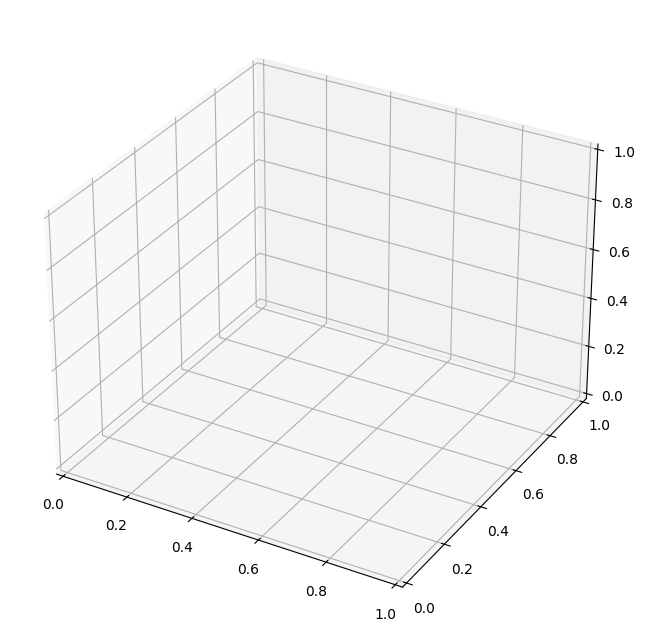

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
import cadquery as cq
import math
import trimesh
import numpy as np
import tempfile
import os
import matplotlib.pyplot as plt

# === PARAMÈTRES GÉNÉRAUX ===
diametre_couronne = 80
hauteur_couronne = 20
diametre_cylindre = 8
hauteur_cylindre = 20
rayon_positionnement = 20
nombre_cylindres = 8

def cadquery_to_trimesh(cq_obj):
    """Convertit un objet CadQuery en maillage Trimesh."""
    with tempfile.NamedTemporaryFile(suffix=".stl", delete=False) as tmp:
        cq.exporters.export(cq_obj, tmp.name)
        mesh = trimesh.load(tmp.name)
    os.remove(tmp.name)
    return mesh

def visualiser(meshes, couleurs, alphas, ax):
    """Affiche plusieurs maillages sur un graphique 3D."""
    ax.clear()
    for mesh, couleur, alpha in zip(meshes, couleurs, alphas):
        ax.plot_trisurf(
            mesh.vertices[:, 0], mesh.vertices[:, 1], mesh.vertices[:, 2],
            triangles=mesh.faces, shade=True, color=couleur, alpha=alpha
        )
    ax.set_xlim(-100, 100)
    ax.set_ylim(-100, 100)
    ax.set_zlim(0, 100)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

def creer_couronne():
    """Crée la couronne avec un évidement central."""
    base = (
        cq.Workplane("YZ")
        .center(-(rayon_positionnement + diametre_cylindre), diametre_couronne / 2)
        .circle(diametre_couronne / 2)
        .extrude(-hauteur_couronne)
    )

    vide = (
        cq.Workplane("YZ")
        .center(-(rayon_positionnement + diametre_cylindre), diametre_couronne / 2)
        .circle(diametre_couronne / 2 - hauteur_cylindre)
        .extrude(-hauteur_couronne)
    )

    couronne = base.cut(vide)
    return couronne

def creer_pignon():
    """Crée un pignon composé de plusieurs cylindres répartis en cercle."""
    cylindres = []
    for i in range(nombre_cylindres):
        angle = i * (360 / nombre_cylindres)
        x = rayon_positionnement * math.cos(math.radians(angle))
        y = rayon_positionnement * math.sin(math.radians(angle))

        cylindre = (
            cq.Workplane("XY")
            .center(x, y)
            .circle(diametre_cylindre / 2)
            .extrude(hauteur_cylindre)
        )
        cylindres.append(cylindre)

    pignon = cylindres[0]
    for cylindre in cylindres[1:]:
        pignon = pignon.union(cylindre)

    return pignon

def rotation_pignon_couronne_simultanee(nb_iterations):
    angle_couronne = 360 / nb_iterations
    angle_pignon = angle_couronne * (1 + diametre_couronne / (2 * rayon_positionnement))

    couronne = creer_couronne()
    pignon_original = creer_pignon()


    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    for i in range(nb_iterations):
        angle_orbite = i * angle_couronne
        angle_spin = i * angle_pignon

        x_orbit = (rayon_positionnement + diametre_cylindre) * math.cos(math.radians(angle_orbite))
        y_orbit = (rayon_positionnement + diametre_cylindre) * math.sin(math.radians(angle_orbite))

        pignon = pignon_original.rotate((0, 0, 0), (0, 0, 1), angle_spin)
        pignon = pignon.translate((x_orbit, y_orbit, 0))

        try:
            intersection = pignon.intersect(couronne)
            if hasattr(intersection, 'val') and intersection.val().Vertices():
                mesh_inter = cadquery_to_trimesh(intersection)
                mesh_pignon = cadquery_to_trimesh(pignon)
                mesh_couronne = cadquery_to_trimesh(couronne)

                visualiser([mesh_couronne, mesh_pignon, mesh_inter], ['blue', 'green', 'red'], [0.1, 0.1, 0.8], ax)
                plt.show()
        except Exception as e:
            print(f"Iteration {i}: Erreur d'intersection – {e}")
            continue

        plt.draw()
        plt.pause(0.1)

        plt.show()

rotation_pignon_couronne_simultanee(12)


Support for third party widgets will remain active for the duration of the session. To disable support:

In [ ]:
from google.colab import output
output.disable_custom_widget_manager()

In [ ]:
# Configuration de la scène et de la caméra
scene = Scene()
camera = PerspectiveCamera(position=[200, 200, 200], fov=75, aspect=640/480, near=0.1, far=1000)
camera.lookAt([0, 0, 0])

# Ajout de lumières pour mieux voir l'objet
ambient_light = AmbientLight(color='#FFFFFF', intensity=0.5)
scene.add(ambient_light)
directional_light = DirectionalLight(color='#FFFFFF', intensity=0.8, position=[1, 1, 1])
scene.add(directional_light)

# Ajout du maillage à la scène
scene.add(show(mesh))

# Création du Renderer
renderer = Renderer(scene=scene, camera=camera, controls=[OrbitControls(controlling=camera)], background_color='#f0f0f0', width=640, height=480)
display(renderer)

Renderer(camera=PerspectiveCamera(aspect=1.3333333333333333, far=1000.0, fov=75.0, position=(200.0, 200.0, 200…

In [ ]:
# === BOUCLE DES GALETS ET AXES POUR SCULPTER LA COURONNE ===
for i in range(nb_galets):
    angle = math.radians(i * angle_step)
    rotation_angle = angle * (diametre_couronne / diametre_pignon)

    x = rayon_orbite * math.cos(angle)
    y = rayon_orbite * math.sin(angle)

    galet = (cq.Workplane("XY")
             .circle(diametre_galet / 2)
             .extrude(longueur_galet)
             .translate((x, y, 0))
             .rotate((0, 0, 0), (0, 0, 1), math.degrees(rotation_angle)))
    couronne = couronne.cut(galet)

    dx = math.cos(angle)
    dy = math.sin(angle)
    axe_x = x + rayon_pignon * dy
    axe_y = y - rayon_pignon * dx

    axe = (cq.Workplane("XY")
           .center(axe_x, axe_y)
           .circle(diametre_axe / 2)
           .extrude(longueur_galet + 2 * axe_depassement)
           .translate((0, 0, -axe_depassement)))
    couronne = couronne.cut(axe)

    # Visualisation après chaque modification
    mesh = cadquery_to_trimesh(couronne)
    scene = Scene()
    camera = PerspectiveCamera(position=[200, 200, 200], fov=75, aspect=640/480, near=0.1, far=1000)
    camera.lookAt([0, 0, 0])

    scene.add(AmbientLight(color='#FFFFFF', intensity=0.5))
    scene.add(DirectionalLight(color='#FFFFFF', intensity=0.8, position=[1, 1, 1]))

    scene.add(show(mesh))

    renderer = Renderer(scene=scene, camera=camera, controls=[OrbitControls(controlling=camera)], background_color='#f0f0f0', width=640, height=480)
    display(renderer)

Renderer(camera=PerspectiveCamera(aspect=1.3333333333333333, far=1000.0, fov=75.0, position=(200.0, 200.0, 200…

Renderer(camera=PerspectiveCamera(aspect=1.3333333333333333, far=1000.0, fov=75.0, position=(200.0, 200.0, 200…

Renderer(camera=PerspectiveCamera(aspect=1.3333333333333333, far=1000.0, fov=75.0, position=(200.0, 200.0, 200…

Renderer(camera=PerspectiveCamera(aspect=1.3333333333333333, far=1000.0, fov=75.0, position=(200.0, 200.0, 200…

Renderer(camera=PerspectiveCamera(aspect=1.3333333333333333, far=1000.0, fov=75.0, position=(200.0, 200.0, 200…

Renderer(camera=PerspectiveCamera(aspect=1.3333333333333333, far=1000.0, fov=75.0, position=(200.0, 200.0, 200…

Renderer(camera=PerspectiveCamera(aspect=1.3333333333333333, far=1000.0, fov=75.0, position=(200.0, 200.0, 200…

Renderer(camera=PerspectiveCamera(aspect=1.3333333333333333, far=1000.0, fov=75.0, position=(200.0, 200.0, 200…

Renderer(camera=PerspectiveCamera(aspect=1.3333333333333333, far=1000.0, fov=75.0, position=(200.0, 200.0, 200…

Renderer(camera=PerspectiveCamera(aspect=1.3333333333333333, far=1000.0, fov=75.0, position=(200.0, 200.0, 200…

Renderer(camera=PerspectiveCamera(aspect=1.3333333333333333, far=1000.0, fov=75.0, position=(200.0, 200.0, 200…

Renderer(camera=PerspectiveCamera(aspect=1.3333333333333333, far=1000.0, fov=75.0, position=(200.0, 200.0, 200…

In [ ]:
import cadquery as cq
import math
import os
import trimesh
import numpy as np
import tempfile
from pythreejs import Scene, PerspectiveCamera, Mesh, MeshStandardMaterial, BufferGeometry, BufferAttribute, Renderer, AmbientLight, DirectionalLight

# === PARAMÈTRES ===
diametre_pignon = 40
diametre_couronne = 80
largeur_couronne = 12
nb_galets = 12
diametre_galet = 6
diametre_axe = 3
longueur_galet = 12
axe_depassement = 5

# === CALCULS GÉOMÉTRIQUES ===
rayon_pignon = diametre_pignon / 2
rayon_orbite = (diametre_couronne / 2) - rayon_pignon
angle_step = 360 / nb_galets

# === CRÉATION DE LA COURONNE DE BASE ===
couronne = cq.Workplane("XY").circle(diametre_couronne / 2).extrude(largeur_couronne)

# Fonction pour visualiser le maillage
def show(mesh):
    geometry = BufferGeometry(attributes={
        'position': BufferAttribute(array=mesh.vertices, normalized=False),
        'normal': BufferAttribute(array=mesh.vertex_normals, normalized=True)
    })
    material = MeshStandardMaterial(color='gray', side='DoubleSide')
    return Mesh(geometry=geometry, material=material)

# Fonction pour convertir un objet CadQuery en maillage trimesh
def cadquery_to_trimesh(cadquery_object):
    with tempfile.NamedTemporaryFile(suffix=".stl", delete=False) as tmp_file:
        cq.exporters.export(cadquery_object, tmp_file.name)
        mesh = trimesh.load(tmp_file.name)
    os.unlink(tmp_file.name)  # Supprime le fichier temporaire
    return mesh

# Visualisation de la couronne de base
mesh = cadquery_to_trimesh(couronne)

# Configuration de la scène et de la caméra
scene = Scene()
camera = PerspectiveCamera(position=[200, 200, 200], fov=75, aspect=640/480, near=0.1, far=1000)
camera.lookAt([0, 0, 0])

# Ajout de lumières pour mieux voir l'objet
ambient_light = AmbientLight(color='#FFFFFF', intensity=0.5)
scene.add(ambient_light)
directional_light = DirectionalLight(color='#FFFFFF', intensity=0.8, position=[1, 1, 1])
scene.add(directional_light)

# Ajout du maillage à la scène
scene.add(show(mesh))

# Création du Renderer
renderer = Renderer(scene=scene, camera=camera, controls=[OrbitControls(controlling=camera)], background_color='#f0f0f0', width=640, height=480)
display(renderer)

# === BOUCLE DES GALETS ET AXES POUR SCULPTER LA COURONNE ===
for i in range(nb_galets):
    angle = math.radians(i * angle_step)
    rotation_angle = angle * (diametre_couronne / diametre_pignon)

    x = rayon_orbite * math.cos(angle)
    y = rayon_orbite * math.sin(angle)

    galet = (cq.Workplane("XY")
             .circle(diametre_galet / 2)
             .extrude(longueur_galet)
             .translate((x, y, 0))
             .rotate((0, 0, 0), (0, 0, 1), math.degrees(rotation_angle)))
    couronne = couronne.cut(galet)

    dx = math.cos(angle)
    dy = math.sin(angle)
    axe_x = x + rayon_pignon * dy
    axe_y = y - rayon_pignon * dx

    axe = (cq.Workplane("XY")
           .center(axe_x, axe_y)
           .circle(diametre_axe / 2)
           .extrude(longueur_galet + 2 * axe_depassement)
           .translate((0, 0, -axe_depassement)))
    couronne = couronne.cut(axe)

    # Visualisation après chaque modification
    mesh = cadquery_to_trimesh(couronne)
    scene = Scene()
    camera = PerspectiveCamera(position=[200, 200, 200], fov=75, aspect=640/480, near=0.1, far=1000)
    camera.lookAt([0, 0, 0])

    scene.add(AmbientLight(color='#FFFFFF', intensity=0.5))
    scene.add(DirectionalLight(color='#FFFFFF', intensity=0.8, position=[1, 1, 1]))

    scene.add(show(mesh))

    renderer = Renderer(scene=scene, camera=camera, controls=[OrbitControls(controlling=camera)], background_color='#f0f0f0', width=640, height=480)
    display(renderer)

# === EXPORT DES FICHIERS
os.makedirs("/content/export", exist_ok=True)
step_path = "/content/export/couronne_trochoidale.step"
stl_path = "/content/export/couronne_trochoidale.stl"

cq.exporters.export(couronne, step_path)
cq.exporters.export(couronne, stl_path)


AttributeError: 'Workplane' object has no attribute 'Vertices'